# Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
recording from these individuals ("name" column). The main aim of the data 
is to discriminate healthy people from those with PD, according to "status" 
column which is set to 0 for healthy and 1 for PD.

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB  

import warnings
warnings.filterwarnings("ignore")


sns.set_style(style='darkgrid')

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

- There are 24 columns in total
    - One target column - 'status'
    - One column which can be the index - 'name'
    - 22 predictor variables
- There are no null values 

In [0]:
df.set_index('name', inplace = True)

In [0]:
sns.pairplot(df, hue = 'status', diag_kind = 'kde', palette='GnBu_d')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

- There is some heavy multicollinearity among a few variables
- Seeing individual distributions of the predictors, 'PPE' can be a good predictor 
- Most of them idividually are quiet weak predictors

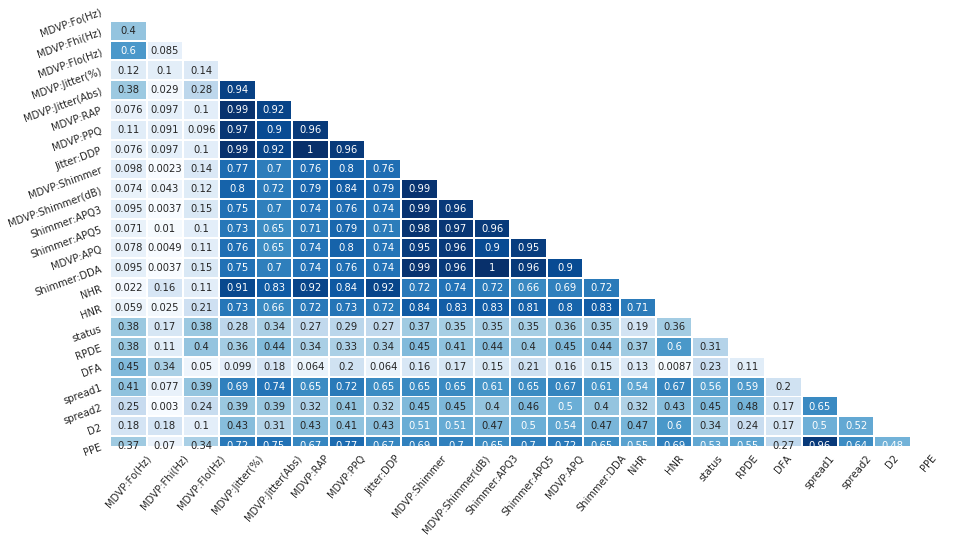

In [0]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

- There is good amount of correlation among a few variables
- Let's go through the first iteration f model building and later we will deal with multi-collinearity

In [0]:
X = df.drop(columns='status')   # predictors
y = df.status     # target

In [0]:
from sklearn.preprocessing import StandardScaler    # to scale the data
from sklearn.model_selection import train_test_split  # to split the data into test and train sets

scaler = StandardScaler()   # creating a scaler object

'''To avoid data leakage, we will fit the scaler object using the train set and then transform the train and test sets using
the fitted Scaler object'''

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 1,
                                                    stratify = y)# Stratify y to keep the class proportions consistent

scaler.fit(X_train)  # fitting the scaler object using the train data

X_train_scaled = scaler.transform(X_train)  # transform the train set
X_test_scaled = scaler.transform(X_test)    # transform the test set

'''Because .transform returns nd arrays, assigning them back to the respective dataframes to retain dataframe structure,
but with scaled values'''

X_train.iloc[:,:] = X_train_scaled 
X_test.iloc[:,:] = X_test_scaled

In [0]:
extra_samples = y_train[y_train == 0].sample(70,replace = True, random_state=1).index # Generate duplicate samples
y_train = y_train.append(y_train.loc[extra_samples])  # use the index of the duplicate samples to append to the y_train

extra_samples = X_train.loc[extra_samples]   # use the same index to generate duplicate rows in X_train
X_train = X_train.append(extra_samples)  # append these duplicate rows to X_train

In [0]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input
    from sklearn import metrics
    
    model.fit(X_train, y_train)   # fit the model using the train data

    pred_train = model.predict(X_train)   # model predictions on the train data
    pred_test = model.predict(X_test)     # model predictions on the test data

    score = round(model.score(X_test, y_test), 3)   # accuracy on the test data


    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_test).ravel()  # confusion matrix for y_test and pred_test

    recall = round(tp/(tp+fn), 3)     # calculate recall
    precision = round(tp/(tp+fp), 3)  # calculate precision
    specificity =round(tn/(tn+fp),3)  # calculate specificity
    f1_score =  round(2*precision*recall/(precision + recall), 3)   # calculate f1 score
    
    
    return score, recall, precision, specificity, f1_score, pred_train, pred_test  # return all the metrics

In [0]:
lr = LogisticRegression(solver = 'liblinear')        # Create a Logistic Regression model object 
knn = KNeighborsClassifier()                         # Create a KNN model object 
nb = GaussianNB()                                    # Create a Naive Bayes' model object 
svm = SVC(gamma = 'auto', kernel= 'poly', degree=1)  # Create an SVM model object 

result = {}   # Create an empty dictionary to later use to store metrics of each of the models


# putting all 4 models in a for loop and appending the results of each of the models to the result dictionary
for model, name  in list(zip([lr, knn, nb, svm], ['Logistic Regression', 'KNN', 'Naive Bayes', 'SVM'])):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)
    
result1 = pd.DataFrame(np.array(list(result.values()))[:,0:5],    # make a dataframe out of the metrics from result dictionary 
                       columns= ['Accuracy','Recall','Precision','Specificity','F1 Score'], # name the columns appropriatly
                      index= result.keys())   # use the model names as index

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'

result1 

,Accuracy,Recall,Precision,Specificity,F1 Score
Model,,,,,
Logistic Regression,0.796,0.811,0.909,0.75,0.857
KNN,0.898,0.865,1,1,0.928
Naive Bayes,0.735,0.703,0.929,0.833,0.8
SVM,0.735,0.73,0.9,0.75,0.806


- With minimal preprocessing, we got the above results
- For additional preprocesing steps, we can eliminate few attributes using VIF to get rid of multicollinearity, we can treat outliers, a more of an advanced methods will be to use PCA which will reduce dimensions and also get rid of multicollinearity
- But for now, we will carry on with the processed data that we have

**Let's put(stack) these above models together to constitute a single Stacked Ensemble model and see if the predictions get better**

In [0]:
train_X  = np.array([list(result[x][5]) for x in list(result)]).transpose()  # predictions from each model on the train set

test_X = np.array([list(result[x][6]) for x in list(result)]).transpose()  # predictions from each model on the test set

In [0]:
meta = BernoulliNB()                          # Create a Naive Bayes classifier object to be used as a meta classifier

# use fit_n_print and assign the metrics to result1
result1.loc['Meta Classifier(NB)'] = fit_n_print(meta, train_X, test_X, y_train, y_test)[0:5]

In [0]:
meta_dt = DecisionTreeClassifier(random_state= 1)

result1.loc['Meta Classifier(DT)'] = fit_n_print(meta_dt, train_X, test_X, y_train, y_test)[0:5]

In [0]:
rf = RandomForestClassifier(random_state=1, n_estimators=10)  # specifying the n_estimators to silence a future warning

rf_accuracy, rf_recall, rf_precision, rf_specificity, rf_f1_score = fit_n_print(rf, X_train, X_test, y_train, y_test)[0:5]
result1.loc['Random Forest'] = rf_accuracy, rf_recall, rf_precision, rf_specificity, rf_f1_score

In [0]:
result1

,Accuracy,Recall,Precision,Specificity,F1 Score
Model,,,,,
Logistic Regression,0.796,0.811,0.909,0.75,0.857
KNN,0.898,0.865,1,1,0.928
Naive Bayes,0.735,0.703,0.929,0.833,0.8
SVM,0.735,0.73,0.9,0.75,0.806
Meta Classifier(NB),0.857,0.892,0.917,0.75,0.904
Meta Classifier(DT),0.857,0.865,0.941,0.833,0.901
Random Forest,0.959,1,0.949,0.833,0.974


# Result: 

* Of all the models, KNN and Random Forest stood out and gave the best metrics
* Between the two, I would pick Random Forest as my final model because it has better numbers overall

# Conclusion:
* We have seen how to use Ensemble models in this project
* There are other popular Ensemble models that we can further try out
* The way we have assessed these models is weak
* We will learn how we can assess models better and get to metrics that are more reliable in the upcoming models




